In [3]:
import os
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Run -defaults write org.python.python ApplePersistenceIgnoreState NO- before executing -python3 <filename>- if running from mac terminal


In [47]:
class solver():

  def __init__(self,
              scheme_acronym, 
              fluid_velocity = 1,
              fluid_density = 0.5,
              Gamma = 0.5,
              domain_L = 1,
              inlet_bc = 100,
              outlet_bc = 20,
              gridpoints = 10
              ):
    
    # Global Attributes
    self.scheme = scheme_acronym
    self.angp_ratio = 50
    
    self.u = fluid_velocity
    self.rho = fluid_density
    self.Gamma = Gamma
    self.L = domain_L
    self.dx = self.L/gridpoints
    self.global_Pe = self.rho * self.u * self.L / self.Gamma
    self.local_Pe = self.rho * self.u * self.dx / self.Gamma
    
    self.x = np.linspace(0,self.L,gridpoints)
    self.analytical_x = np.linspace(0,self.L,self.angp_ratio*gridpoints)
    self.phi_0 = inlet_bc
    self.phi_L = outlet_bc
    
    self.analytical_phi = np.zeros(self.angp_ratio*gridpoints)
    self.phi = np.zeros(gridpoints)
    self.P = np.zeros(gridpoints)
    self.Q = np.zeros(gridpoints)
    self.error = 0

    #Solve for phi and calc error
    if self.scheme == "CDS": self.CDS()
    elif self.scheme == "UDS": self.UDS()
    elif self.scheme == "PLDS": self.PLDS()
    self.analytical_soln()
    self.numerical_error()

  # Getter methods
  def get_local_Pe(self): return self.local_Pe
  def get_x(self): return self.x
  def get_anx(self): return self.analytical_x
  def get_P(self): return self.P
  def get_Q(self): return self.Q
  def get_numerical_phi(self): return self.phi
  def get_analytical_phi(self): return self.analytical_phi
  def get_rho(self): return self.rho
  def get_u(self): return self.u
  def get_Gamma(self): return self.Gamma
  def get_gridpoint_n(self): return int(self.L/self.dx)
  def get_dx(self): return self.dx
  def get_error(self): return self.error


  # Discretization Schemes
  def CDS(self):
    D = self.Gamma / self.dx
    F = self.rho * self.u
    #Coefficients
    a = 2*D
    b = D - 0.5 * F
    c = D + 0.5 * F

    self.TDMA(a,b,c)
  
  def UDS(self):
    D = self.Gamma / self.dx
    F = self.rho * self.u
    #Coefficients
    a = 2*D + max(F,0) + max(-F,0)
    b = D + max(-F,0)
    c = D + max(F,0)
  
    self.TDMA(a,b,c)

  def PLDS(self):
    D = self.Gamma / self.dx
    F = self.rho * self.u
    #Coefficients

    if self.local_Pe > 10:
      b = max(-F,0)
      c = max(F,0)
      a = b + c
    else: 
      b = D*max((1-0.1*abs(self.local_Pe))**5,0) + max(-F,0)
      c = D*max((1-0.1*abs(self.local_Pe))**5,0) + max(F,0)
      a = b + c
  
    self.TDMA(a,b,c)



  ## Use Linear Algebraic Equation Solution Algorithm TDMA
  def TDMA(self,a,b,c):
    # Set BCs
    self.P[0], self.P[-1] = 0,0
    self.Q[0], self.Q[-1] = self.phi_0, self.phi_L

    # Forward Pass to calculate P and Q
    for i in [x+1 for x in range(len(self.x)-2)]:
      self.P[i] = b / (a - c*self.P[i-1])
      self.Q[i] = c*self.Q[i-1] / (a - c*self.P[i-1])

    # Backward Pass to calculate phi
    self.phi[-1] = self.Q[-1]
    for i in [y for y in range(len(self.x)-1)][::-1]:
      self.phi[i] = self.P[i] * self.phi[i+1] + self.Q[i]
  



  def analytical_soln(self):
    if self.u == 0:
      self.analytical_phi = (self.phi_L-self.phi_0)/self.L * self.analytical_x + self.phi_0
    else:
      self.analytical_phi = self.phi_0 + (np.exp(self.global_Pe * self.analytical_x/self.L)-1)/(np.exp(self.global_Pe)-1) * (self.phi_L-self.phi_0)

  def numerical_error(self):
    for i in range(len(self.phi)):
      self.error += 100*self.dx/self.L * abs((self.phi[i]-self.analytical_phi[self.angp_ratio*i])/self.analytical_phi[self.angp_ratio*i])
    

  

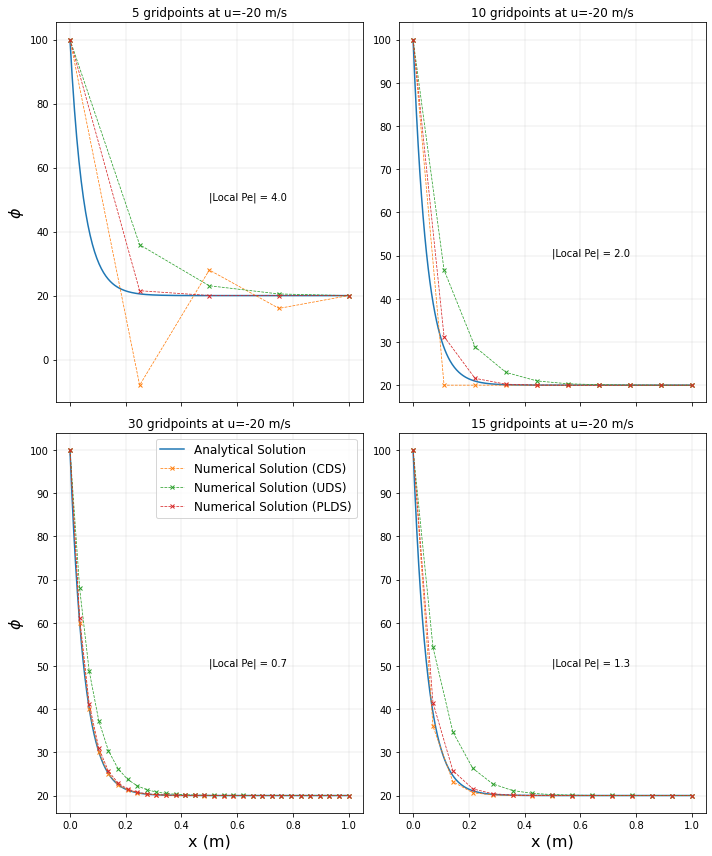

In [39]:
velocity = -20
gp_list = [5,10,15,30]

fig = plt.figure(figsize=(10,12))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1],sharex=ax1)
ax3 = fig.add_subplot(gs[1, 1],sharex=ax1)
ax4 = fig.add_subplot(gs[1, 0],sharex=ax1)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

lstyles = ['dashed','dashdotted','densely dashed','densely dashdotted','solid']
lwidth = ['1.5' for x in range(4)] + ['2.5']
for i,axis in enumerate([ax1,ax2,ax3,ax4]):
  
  gridpoints = gp_list[i]
  solve_CDS = solver('CDS',fluid_velocity=velocity,gridpoints=gridpoints)
  solve_UDS = solver('UDS',fluid_velocity=velocity,gridpoints=gridpoints)
  solve_PLDS = solver('PLDS',fluid_velocity=velocity,gridpoints=gridpoints) 
  
  axis.plot(solve_CDS.get_anx(),solve_CDS.get_analytical_phi(),label='Analytical Solution')
  axis.plot(solve_CDS.get_x(),solve_CDS.get_numerical_phi(),label=f'Numerical Solution (CDS)',linewidth=0.75,linestyle='--',marker='x',markersize=4)
  axis.plot(solve_UDS.get_x(),solve_UDS.get_numerical_phi(),label=f'Numerical Solution (UDS)',linewidth=0.75,linestyle='--',marker='x',markersize=4)
  axis.plot(solve_PLDS.get_x(),solve_PLDS.get_numerical_phi(),label=f'Numerical Solution (PLDS)',linewidth=0.75,linestyle='--',marker='x',markersize=4)

  if velocity>=0: legend_loc='lower left'
  if velocity<0: legend_loc='upper right'
  if i==3: axis.legend(loc=legend_loc,fontsize=12)
  axis.set_title(f'{gridpoints} gridpoints at u={velocity} m/s')
  if i!= 0 and i!= 1: axis.set_xlabel('x (m)',fontsize=16)
  if i!= 1 and i!= 2: axis.set_ylabel(r'$\phi$',fontsize=16)
  axis.grid(linewidth=0.2) 
  axis.annotate(f'|Local Pe| = {abs(round(velocity/gridpoints,1))}',xy=(0.5,50))
plt.tight_layout()
plt.savefig(f'test',dpi=800)




In [64]:
## Plot error (all schemes) for different u values
def scheme_errors():
  
  for velocity in np.linspace(-50,50,11):
    fig = plt.figure()
    for scheme in ['CDS','UDS','PLDS']:
      error_list = []
      gp_list = np.linspace(1,50,50-1)
      for gridpoints in gp_list:
        solve = solver(scheme,fluid_velocity=velocity,gridpoints=int(gridpoints))
        error_list.append(solve.get_error())
      
      plt.plot(gp_list,error_list,label=f'scheme = {scheme}')
      plt.title(f'Error of numerical Solution for u={velocity}m/s')
      plt.ylabel('% Error ')
      plt.xlabel('Number of Gridpoints (1/$\delta$x)')

    plt.legend()
    plt.show()




## Plot error (range of u values) for different schemes
def scheme_errors_func_u():

  for scheme in ['CDS','UDS','PLDS']:
    fig = plt.figure()
    max_gp = 200
    for u in np.linspace(-10,10,11):
      error_list = []
      gp_list = np.linspace(1,max_gp,max_gp-1)
      for gridpoints in gp_list:
        solve = solver(scheme,gridpoints=int(gridpoints),fluid_velocity=u)
        error_list.append(solve.get_error())


      plt.plot(gp_list,error_list,linewidth=0.5,label=f'u = {u}m/s')
      plt.title(f'Error of numerical {scheme} Solution w.r.t the Analytical Solution')
      plt.ylabel('% Error ')
      plt.xlabel('Number of Gridpoints (1/$\delta$x)')

    plt.legend(loc='lower right',prop={'size': 6})
    plt.savefig(f'test{scheme}',dpi=800)

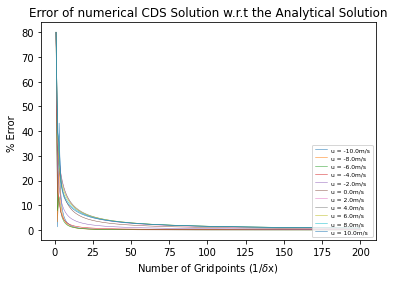

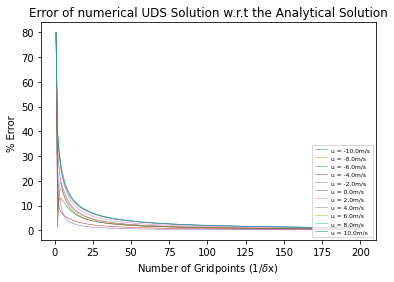

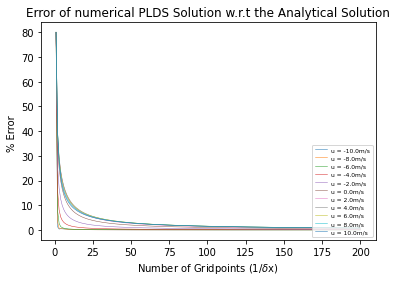

In [65]:
scheme_errors_func_u()

In [ ]:
#Generate Plot Sweep if folder doesnt exist
if not os.path.exists('Individual_test_plots'):
  os.makedirs('Individual_test_plots')
while True:
  print("Do you want to generate a range of error plots and phi distribution plots for different parameter combinations?\n\t yes \n\t no")
  input_a = input()
  if input_a.lower() == 'yes':
    if not os.path.exists('all_plots'):
      os.makedirs('all_plots/error_plots/scheme_errors')
      os.makedirs('all_plots/error_plots/scheme_errors_func_u')
      
      for velocity in [-50,-20,-5,0,5,20,50]:
        os.makedirs(f'all_plots/phi_distribution_plots/{int(velocity)}m_per_s')
    
    print('Currently generating and saving in the all_plots directory. This will take around 2 mins ...')

    #Swept Distribution profile
    for count,velocity in enumerate([-50,-20,-5,0,5,20,50]):
      print(f"\n{round(100/8*(count))}% completed\n")
      for gridpoints in [5,10,20,50,500]:
        phi_distribution_plot(velocity,gridpoints,sweep=True)
    
    print("\n90% completed\n")
    #Error Plots
    scheme_errors_func_u()
    scheme_errors()
    print('Done!\n')

  elif input_a.lower() == 'no': break
  else:
    print('Please answer: yes or no')
    continue
  print('You can find plots of a range of parameters in the all_plots directory.')
  break

print('This UI is for testing distribution of phi with specific (Velocity, Gridpoint Number) pairs.\n')

tryagain = True
while tryagain:
  #Ask user what fluid velocity and number of gridpoints they would like to try
  attribute_prompt = {'constant fluid velocity':('m/s',' or float'),
                      'number of gridpoints':('','')}
  for attribute, dec in attribute_prompt.items():
    while True:
      print(f"What {attribute} would you like to test? Please enter an integer{dec[1]}.")
      num_attribute = input()
      try: num_attribute = int(num_attribute)
      except ValueError:
        try: num_attribute = float(num_attribute)
        except ValueError: continue
      if attribute == 'constant fluid velocity': 
        velocity = num_attribute
        print(f'The {attribute} in the domain has been set to {velocity} {dec[0]}')
      if attribute == 'number of gridpoints': 
        gridpoints = int(num_attribute)
        print(f'The {attribute} in the domain has been set to {gridpoints} {dec[0]}')
      break
  

  print('Solving equation in the Domain ...')
  status_str = phi_distribution_plot(velocity,gridpoints)
  print(status_str)
  while True:
    print('\nWould you like to try another pair?\n\t yes \n\t no')
    input_a = input()
    if input_a.lower() == 'yes': 
      break
    elif input_a.lower() == 'no':
      tryagain = False 
      break
    else: 
      print('Please answer: yes or no')
      continue



    

